In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline


from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder


In [2]:
def load_data(train_path, test_path):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

train_path = "train_data_task1.csv"
test_path  = "test_data_task1.csv"
df_train, df_test = load_data(train_path, test_path)

df_train.head()

id  Birth_Date  Weight   Height Urban_Rural      Occupation Insurance_Type  \
0   1  1994-07-01    64.9  155.0cm       Urban      Unemployed          UEBMI   
1   2  1992-07-16    61.4  171.0cm       Urban  Factory Worker          UEBMI   
2   3  1948-06-23    60.7  170.0cm       Rural      Unemployed          NRCMS   
3   4  1954-11-26    70.2  171.0cm       Urban          Farmer          URBMI   
4   5  1979-07-08   100.3  186.0cm       Rural   Office Worker       Self-pay   

  Family_History Cancer_Type Stage_at_Diagnosis  ... Tumor_Size Surgery_Date  \
0             No      Breast                 II  ...        8.0   2024-10-19   
1            Yes      Breast                  I  ...       10.0   2021-02-28   
2             No     Stomach                 IV  ...       13.0   2022-09-25   
3            Yes    Cervical                 IV  ...        3.0   2024-09-13   
4            Yes        Lung                 II  ...       12.0   2023-12-08   

                                  Chemotherapy_Drugs Radiation_Sessions  \
0                   Paclitaxel,Docetaxel,Doxorubicin                 16   
1  Cyclophosphamide,Paclitaxel,Doxorubicin,Docetaxel                 10   
2                             Fluorouracil,Cisplatin                 21   
3                                          Cisplatin                 10   
4                            Gemcitabine,Carboplatin                  6   

  Immunotherapy  Targeted_Therapy Recurrence_Status Smoking_History  \
0            No               Yes                NO           Never   
1            No                No               Yes          Former   
2           Yes                No                NO          Former   
3            No               Yes                NO           Never   
4           Yes                No               Yes          Former   

  Alcohol_Use label  
0     Regular     1  
1     Regular     1  
2       Never     0  
3     Regular     1  
4       Never     0  

[5 rows x 22 columns]

In [3]:
print(df_train.isnull().sum())

id                       0
Birth_Date               0
Weight                   0
Height                   0
Urban_Rural              0
Occupation               0
Insurance_Type           0
Family_History           0
Cancer_Type              0
Stage_at_Diagnosis       0
Diagnosis_Date           0
Symptoms               501
Tumor_Size               0
Surgery_Date          7575
Chemotherapy_Drugs    4050
Radiation_Sessions       0
Immunotherapy            0
Targeted_Therapy         0
Recurrence_Status        0
Smoking_History          0
Alcohol_Use              0
label                    0
dtype: int64


In [4]:
print(df_test.isnull().sum())

id                     0
Birth_Date            13
Weight                 0
Height                 0
Urban_Rural            0
Occupation             0
Insurance_Type         0
Family_History         0
Cancer_Type            0
Stage_at_Diagnosis     0
Diagnosis_Date         0
Symptoms               0
Tumor_Size             0
Surgery_Date           0
Chemotherapy_Drugs     0
Radiation_Sessions     0
Immunotherapy          0
Targeted_Therapy       0
Recurrence_Status      0
Smoking_History        0
Alcohol_Use            0
dtype: int64


## Removing numerical NaN values

In [5]:
numerical_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
if 'label' in numerical_cols:
    numerical_cols.remove('label')

num_imputer = SimpleImputer(strategy='median')
df_train[numerical_cols] = num_imputer.fit_transform(df_train[numerical_cols])
df_test[numerical_cols] = num_imputer.transform(df_test[numerical_cols])

## Removing categorical NaN values

In [6]:
df_train['Chemotherapy_Drugs'] = df_train['Chemotherapy_Drugs'].fillna('')
df_test['Chemotherapy_Drugs'] = df_test['Chemotherapy_Drugs'].fillna('')
df_train['Symptoms'] = df_train['Symptoms'].fillna('')
df_test['Symptoms'] = df_test['Symptoms'].fillna('')
df_train['Had_Surgery'] = df_train['Surgery_Date'].notna().astype(int)
df_test['Had_Surgery'] = df_test['Surgery_Date'].notna().astype(int)
df_train['No_Chemo'] = df_train['Chemotherapy_Drugs'].eq('').astype(int)
df_test['No_Chemo'] = df_test['Chemotherapy_Drugs'].eq('').astype(int)


In [7]:
categorical_cols = df_train.select_dtypes(include=['object']).columns.tolist()

label_encoders = {}
for col in categorical_cols:
    combined = pd.concat([df_train[col], df_test[col]])
    le = LabelEncoder()
    le.fit(combined.astype(str))
    df_train[col] = le.transform(df_train[col].astype(str))
    df_test[col] = le.transform(df_test[col].astype(str))
    label_encoders[col] = le

scaler = StandardScaler()
scaled_train_num = scaler.fit_transform(df_train[numerical_cols])
scaled_test_num = scaler.transform(df_test[numerical_cols])

all_features = numerical_cols + categorical_cols
train_combined = np.hstack([scaled_train_num, df_train[categorical_cols]])
test_combined = np.hstack([scaled_test_num, df_test[categorical_cols]])

knn_imputer = KNNImputer(n_neighbors=5)
train_imputed = knn_imputer.fit_transform(train_combined)
test_imputed = knn_imputer.transform(test_combined)

train_num_imputed = train_imputed[:, :len(numerical_cols)]
train_cat_imputed = train_imputed[:, len(numerical_cols):]

test_num_imputed = test_imputed[:, :len(numerical_cols)]
test_cat_imputed = test_imputed[:, len(numerical_cols):]

df_train[numerical_cols] = scaler.inverse_transform(train_num_imputed)
df_test[numerical_cols] = scaler.inverse_transform(test_num_imputed)

for i, col in enumerate(categorical_cols):
    df_train[col] = label_encoders[col].inverse_transform(train_cat_imputed[:, i].astype(int))
    df_test[col] = label_encoders[col].inverse_transform(test_cat_imputed[:, i].astype(int))

In [8]:
print("Train missing values:")
print(df_train.isnull().sum())

print("\nTest missing values:")
print(df_test.isnull().sum())

Train missing values:
id                    0
Birth_Date            0
Weight                0
Height                0
Urban_Rural           0
Occupation            0
Insurance_Type        0
Family_History        0
Cancer_Type           0
Stage_at_Diagnosis    0
Diagnosis_Date        0
Symptoms              0
Tumor_Size            0
Surgery_Date          0
Chemotherapy_Drugs    0
Radiation_Sessions    0
Immunotherapy         0
Targeted_Therapy      0
Recurrence_Status     0
Smoking_History       0
Alcohol_Use           0
label                 0
Had_Surgery           0
No_Chemo              0
dtype: int64

Test missing values:
id                    0
Birth_Date            0
Weight                0
Height                0
Urban_Rural           0
Occupation            0
Insurance_Type        0
Family_History        0
Cancer_Type           0
Stage_at_Diagnosis    0
Diagnosis_Date        0
Symptoms              0
Tumor_Size            0
Surgery_Date          0
Chemotherapy_Drugs    0
Radiati

In [9]:
df_train.head()

id  Birth_Date  Weight   Height Urban_Rural      Occupation  \
0  1.0  1994-07-01    64.9  155.0cm       Urban      Unemployed   
1  2.0  1992-07-16    61.4  171.0cm       Urban  Factory Worker   
2  3.0  1948-06-23    60.7  170.0cm       Rural      Unemployed   
3  4.0  1954-11-26    70.2  171.0cm       Urban          Farmer   
4  5.0  1979-07-08   100.3  186.0cm       Rural   Office Worker   

  Insurance_Type Family_History Cancer_Type Stage_at_Diagnosis  ...  \
0          UEBMI             No      Breast                 II  ...   
1          UEBMI            Yes      Breast                  I  ...   
2          NRCMS             No     Stomach                 IV  ...   
3          URBMI            Yes    Cervical                 IV  ...   
4       Self-pay            Yes        Lung                 II  ...   

                                  Chemotherapy_Drugs Radiation_Sessions  \
0                   Paclitaxel,Docetaxel,Doxorubicin               16.0   
1  Cyclophosphamide,Paclitaxel,Doxorubicin,Docetaxel               10.0   
2                             Fluorouracil,Cisplatin               21.0   
3                                          Cisplatin               10.0   
4                            Gemcitabine,Carboplatin                6.0   

   Immunotherapy Targeted_Therapy Recurrence_Status  Smoking_History  \
0             No              Yes                NO            Never   
1             No               No               Yes           Former   
2            Yes               No                NO           Former   
3             No              Yes                NO            Never   
4            Yes               No               Yes           Former   

  Alcohol_Use label Had_Surgery No_Chemo  
0     Regular     1           1        0  
1     Regular     1           1        0  
2       Never     0           1        0  
3     Regular     1           1        0  
4       Never     0           1        0  

[5 rows x 24 columns]

In [10]:
numerical_features = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df_train.select_dtypes(include=['object', 'category']).columns.tolist()

if 'id' in numerical_features:
    numerical_features.remove('id')
if 'label' in numerical_features:
    numerical_features.remove('label')
if 'label' in categorical_features:
    categorical_features.remove('label')

print("Numerical Features:", numerical_features)
print("\nCategorical Features:", categorical_features)

Numerical Features: ['Weight', 'Tumor_Size', 'Radiation_Sessions']

Categorical Features: ['Birth_Date', 'Height', 'Urban_Rural', 'Occupation', 'Insurance_Type', 'Family_History', 'Cancer_Type', 'Stage_at_Diagnosis', 'Diagnosis_Date', 'Symptoms', 'Surgery_Date', 'Chemotherapy_Drugs', 'Immunotherapy', 'Targeted_Therapy', 'Recurrence_Status', 'Smoking_History', 'Alcohol_Use']


## 

In [11]:
train_stages = df_train['Stage_at_Diagnosis'].unique()
print(train_stages)
test_stages = df_test['Stage_at_Diagnosis'].unique()
print(test_stages)


['II' 'I' 'IV' 'III']
['III' 'II' 'I' 'IV']


In [12]:
ordinal_cols = ['Stage_at_Diagnosis']
clinical_order = ['I', 'II', 'III', 'IV']
ordinal_encoder = OrdinalEncoder(categories=[clinical_order])
df_train['Stage_Encoded'] = ordinal_encoder.fit_transform(df_train[['Stage_at_Diagnosis']]).astype('int') +1
df_test['Stage_Encoded'] = ordinal_encoder.transform(df_test[['Stage_at_Diagnosis']]).astype('int') + 1
df_train.head()

id  Birth_Date  Weight   Height Urban_Rural      Occupation  \
0  1.0  1994-07-01    64.9  155.0cm       Urban      Unemployed   
1  2.0  1992-07-16    61.4  171.0cm       Urban  Factory Worker   
2  3.0  1948-06-23    60.7  170.0cm       Rural      Unemployed   
3  4.0  1954-11-26    70.2  171.0cm       Urban          Farmer   
4  5.0  1979-07-08   100.3  186.0cm       Rural   Office Worker   

  Insurance_Type Family_History Cancer_Type Stage_at_Diagnosis  ...  \
0          UEBMI             No      Breast                 II  ...   
1          UEBMI            Yes      Breast                  I  ...   
2          NRCMS             No     Stomach                 IV  ...   
3          URBMI            Yes    Cervical                 IV  ...   
4       Self-pay            Yes        Lung                 II  ...   

  Radiation_Sessions Immunotherapy  Targeted_Therapy Recurrence_Status  \
0               16.0            No               Yes                NO   
1               10.0            No                No               Yes   
2               21.0           Yes                No                NO   
3               10.0            No               Yes                NO   
4                6.0           Yes                No               Yes   

  Smoking_History  Alcohol_Use label Had_Surgery No_Chemo Stage_Encoded  
0           Never      Regular     1           1        0             2  
1          Former      Regular     1           1        0             1  
2          Former        Never     0           1        0             4  
3           Never      Regular     1           1        0             4  
4          Former        Never     0           1        0             2  

[5 rows x 25 columns]

## Converting Height to numerical variable:

In [13]:
df_train['Height'] = df_train['Height'].str.replace('cm', '').astype(float)
df_test['Height'] = df_test['Height'].str.replace('cm', '').astype(float)


In [14]:
print(df_train['Occupation'].unique())
print(df_train['Insurance_Type'].unique())
print(df_train['Cancer_Type'].unique())



['Unemployed' 'Factory Worker' 'Farmer' 'Office Worker' 'Retired']
['UEBMI' 'NRCMS' 'URBMI' 'Self-pay']
['Breast' 'Stomach' 'Cervical' 'Lung' 'Esophageal' 'Colorectal' 'Liver']


In [15]:
categorical_cols = ['Occupation', 'Insurance_Type', 'Cancer_Type']

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', ohe, categorical_cols)
    ],
    remainder='passthrough'
)

preprocessor.fit(df_train[categorical_cols])

train_encoded = preprocessor.transform(df_train[categorical_cols])
test_encoded = preprocessor.transform(df_test[categorical_cols])

encoded_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)

df_train_encoded = pd.DataFrame(train_encoded, columns=encoded_cols, index=df_train.index)
df_test_encoded = pd.DataFrame(test_encoded, columns=encoded_cols, index=df_test.index)

df_train_encoded = df_train_encoded.astype(bool)
df_test_encoded = df_test_encoded.astype(bool)

df_train = pd.concat([df_train.drop(categorical_cols, axis=1), df_train_encoded], axis=1)
df_test = pd.concat([df_test.drop(categorical_cols, axis=1), df_test_encoded], axis=1)

In [16]:
df_train.head()

id  Birth_Date  Weight  Height Urban_Rural Family_History  \
0  1.0  1994-07-01    64.9   155.0       Urban             No   
1  2.0  1992-07-16    61.4   171.0       Urban            Yes   
2  3.0  1948-06-23    60.7   170.0       Rural             No   
3  4.0  1954-11-26    70.2   171.0       Urban            Yes   
4  5.0  1979-07-08   100.3   186.0       Rural            Yes   

  Stage_at_Diagnosis Diagnosis_Date            Symptoms  Tumor_Size  ...  \
0                 II     2020-02-10  Cough, Weight Loss         8.0  ...   
1                  I     2014-08-17      Blood in Stool        10.0  ...   
2                 IV     2014-09-25    Nausea, Vomiting        13.0  ...   
3                 IV     2021-01-04    Nausea, Vomiting         3.0  ...   
4                 II     2019-07-26  Cough, Weight Loss        12.0  ...   

  Insurance_Type_Self-pay Insurance_Type_UEBMI  Insurance_Type_URBMI  \
0                   False                 True                 False   
1                   False                 True                 False   
2                   False                False                 False   
3                   False                False                  True   
4                    True                False                 False   

  Cancer_Type_Breast Cancer_Type_Cervical Cancer_Type_Colorectal  \
0               True                False                  False   
1               True                False                  False   
2              False                False                  False   
3              False                 True                  False   
4              False                False                  False   

  Cancer_Type_Esophageal Cancer_Type_Liver  Cancer_Type_Lung  \
0                  False             False             False   
1                  False             False             False   
2                  False             False             False   
3                  False             False             False   
4                  False             False              True   

   Cancer_Type_Stomach  
0                False  
1                False  
2                 True  
3                False  
4                False  

[5 rows x 38 columns]

In [17]:
print(df_train['Urban_Rural'].unique())
print(df_train['Family_History'].unique())
print(df_train['Recurrence_Status'].unique())
print(df_train['Smoking_History'].unique())
print(df_train['Alcohol_Use'].unique())

['Urban' 'Rural']
['No' 'Yes']
['NO' 'Yes']
['Never' 'Former' 'Current']
['Regular' 'Never' 'Occasional']


In [18]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

urban_rural_transformer = Pipeline(steps=[
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))
])

df_train_encoded = urban_rural_transformer.fit_transform(df_train[['Urban_Rural']])
df_test_encoded = urban_rural_transformer.transform(df_test[['Urban_Rural']])

df_train_encoded = pd.DataFrame(df_train_encoded.toarray(), columns=urban_rural_transformer.named_steps['one_hot_encoder'].get_feature_names_out(['Urban_Rural']))
df_test_encoded = pd.DataFrame(df_test_encoded.toarray(), columns=urban_rural_transformer.named_steps['one_hot_encoder'].get_feature_names_out(['Urban_Rural']))

df_train_encoded = df_train_encoded.astype(bool)
df_test_encoded = df_test_encoded.astype(bool)

df_train = df_train.join(df_train_encoded)
df_test = df_test.join(df_test_encoded)

df_train = df_train.drop('Urban_Rural', axis=1)
df_test = df_test.drop('Urban_Rural', axis=1)



In [19]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df_train['Family_History'] = label_encoder.fit_transform(df_train['Family_History'])
df_test['Family_History'] = label_encoder.transform(df_test['Family_History'])

df_train['Recurrence_Status'] = label_encoder.fit_transform(df_train['Recurrence_Status'].str.strip())
df_test['Recurrence_Status'] = label_encoder.transform(df_test['Recurrence_Status'].str.strip())

df_train['Smoking_History'] = label_encoder.fit_transform(df_train['Smoking_History'])
df_test['Smoking_History'] = label_encoder.transform(df_test['Smoking_History'])

df_train['Alcohol_Use'] = label_encoder.fit_transform(df_train['Alcohol_Use'])
df_test['Alcohol_Use'] = label_encoder.transform(df_test['Alcohol_Use'])

df_train.head()



id  Birth_Date  Weight  Height  Family_History Stage_at_Diagnosis  \
0  1.0  1994-07-01    64.9   155.0               0                 II   
1  2.0  1992-07-16    61.4   171.0               1                  I   
2  3.0  1948-06-23    60.7   170.0               0                 IV   
3  4.0  1954-11-26    70.2   171.0               1                 IV   
4  5.0  1979-07-08   100.3   186.0               1                 II   

  Diagnosis_Date            Symptoms  Tumor_Size Surgery_Date  ...  \
0     2020-02-10  Cough, Weight Loss         8.0   2024-10-19  ...   
1     2014-08-17      Blood in Stool        10.0   2021-02-28  ...   
2     2014-09-25    Nausea, Vomiting        13.0   2022-09-25  ...   
3     2021-01-04    Nausea, Vomiting         3.0   2024-09-13  ...   
4     2019-07-26  Cough, Weight Loss        12.0   2023-12-08  ...   

  Insurance_Type_URBMI  Cancer_Type_Breast Cancer_Type_Cervical  \
0                False                True                False   
1                False                True                False   
2                False               False                False   
3                 True               False                 True   
4                False               False                False   

  Cancer_Type_Colorectal  Cancer_Type_Esophageal  Cancer_Type_Liver  \
0                  False                   False              False   
1                  False                   False              False   
2                  False                   False              False   
3                  False                   False              False   
4                  False                   False              False   

   Cancer_Type_Lung  Cancer_Type_Stomach  Urban_Rural_Rural  Urban_Rural_Urban  
0             False                False              False               True  
1             False                False              False               True  
2             False                 True               True              False  
3             False                False              False               True  
4              True                False               True              False  

[5 rows x 39 columns]

In [20]:
def calculate_age(birth_date, diagnosis_date):
    birth_date = pd.to_datetime(birth_date, format='%Y-%m-%d', errors='coerce')
    diagnosis_date = pd.to_datetime(diagnosis_date, format='%Y-%m-%d', errors='coerce')
    age_days = (diagnosis_date - birth_date).dt.days
    return np.floor(age_days / 365.25).astype('Int64')

df_train['Age_at_Diagnosis'] = calculate_age(df_train['Birth_Date'], df_train['Diagnosis_Date'])
df_test['Age_at_Diagnosis'] = calculate_age(df_test['Birth_Date'], df_test['Diagnosis_Date'])

median_age = df_train['Age_at_Diagnosis'].median()
num_imputer = SimpleImputer(strategy='median')
df_train['Age_at_Diagnosis'] = num_imputer.fit_transform(df_train[numerical_cols])
df_test['Age_at_Diagnosis'] = num_imputer.transform(df_test[numerical_cols])

print("NaN values in training set:", df_train['Age_at_Diagnosis'].isnull().sum())
print("NaN values in test set:", df_test['Age_at_Diagnosis'].isnull().sum())

NaN values in training set: 0
NaN values in test set: 0


In [21]:
def calculate_treatment_delay(df):

    df['Diagnosis_Date'] = pd.to_datetime(df['Diagnosis_Date'], format='%Y-%m-%d', errors='coerce')
    df['Surgery_Date'] = pd.to_datetime(df['Surgery_Date'], format='%Y-%m-%d', errors='coerce')
    
    df['Diagnosis_to_Surgery_Days'] = (df['Surgery_Date'] - df['Diagnosis_Date']).dt.days
    
    df['Had_Surgery'] = df['Surgery_Date'].notna().astype(int)
    df.loc[df['Had_Surgery'] == 0, 'Diagnosis_to_Surgery_Days'] = -1
    
    return df

df_train = calculate_treatment_delay(df_train)
df_test = calculate_treatment_delay(df_test)

In [22]:
bins = [-2, -1, 0, 30, 90, 365, np.inf]
labels = ['No_Surgery', 'Same_Day', 'Emergent_less_30d', 'Standard_30-90d', 'Delayed_3-12mo', 'Late_more_1yr']

df_train['Surgery_Timing'] = pd.cut(
    df_train['Diagnosis_to_Surgery_Days'],
    bins=bins,
    labels=labels
)

df_test['Surgery_Timing'] = pd.cut(
    df_test['Diagnosis_to_Surgery_Days'],
    bins=bins,
    labels=labels
)

timing_dummies = pd.get_dummies(df_train['Surgery_Timing'], prefix='Surgery')
df_train = pd.concat([df_train, timing_dummies], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Surgery_Timing'], prefix='Surgery')], axis=1)

In [23]:
df_train.head()

id  Birth_Date  Weight  Height  Family_History Stage_at_Diagnosis  \
0  1.0  1994-07-01    64.9   155.0               0                 II   
1  2.0  1992-07-16    61.4   171.0               1                  I   
2  3.0  1948-06-23    60.7   170.0               0                 IV   
3  4.0  1954-11-26    70.2   171.0               1                 IV   
4  5.0  1979-07-08   100.3   186.0               1                 II   

  Diagnosis_Date            Symptoms  Tumor_Size Surgery_Date  ...  \
0     2020-02-10  Cough, Weight Loss         8.0   2024-10-19  ...   
1     2014-08-17      Blood in Stool        10.0   2021-02-28  ...   
2     2014-09-25    Nausea, Vomiting        13.0   2022-09-25  ...   
3     2021-01-04    Nausea, Vomiting         3.0   2024-09-13  ...   
4     2019-07-26  Cough, Weight Loss        12.0   2023-12-08  ...   

  Urban_Rural_Urban  Age_at_Diagnosis Diagnosis_to_Surgery_Days  \
0              True               1.0                      64.9   
1              True               2.0                      61.4   
2             False               3.0                      60.7   
3              True               4.0                      70.2   
4             False               5.0                     100.3   

  Surgery_Timing  Surgery_No_Surgery  Surgery_Same_Day  \
0  Late_more_1yr               False             False   
1  Late_more_1yr               False             False   
2  Late_more_1yr               False             False   
3  Late_more_1yr               False             False   
4  Late_more_1yr               False             False   

   Surgery_Emergent_less_30d  Surgery_Standard_30-90d  Surgery_Delayed_3-12mo  \
0                      False                    False                   False   
1                      False                    False                   False   
2                      False                    False                   False   
3                      False                    False                   False   
4                      False                    False                   False   

   Surgery_Late_more_1yr  
0                   True  
1                   True  
2                   True  
3                   True  
4                   True  

[5 rows x 48 columns]

## Dropping some columns that we extract some features from them: 

In [24]:
cols_to_drop = [
    # 'Had_Surgery',       
    'Diagnosis_to_Surgery_Days', 
    'Surgery_Date',          
    'Diagnosis_Date',          
    'Birth_Date',
    'Stage_at_Diagnosis',
    'Surgery_Timing'        
]

existing_cols = [col for col in cols_to_drop if col in df_train.columns]
df_train = df_train.drop(existing_cols, axis=1)
df_test = df_test.drop(existing_cols, axis=1)

In [25]:
df_train.head()

id  Weight  Height  Family_History            Symptoms  Tumor_Size  \
0  1.0    64.9   155.0               0  Cough, Weight Loss         8.0   
1  2.0    61.4   171.0               1      Blood in Stool        10.0   
2  3.0    60.7   170.0               0    Nausea, Vomiting        13.0   
3  4.0    70.2   171.0               1    Nausea, Vomiting         3.0   
4  5.0   100.3   186.0               1  Cough, Weight Loss        12.0   

                                  Chemotherapy_Drugs  Radiation_Sessions  \
0                   Paclitaxel,Docetaxel,Doxorubicin                16.0   
1  Cyclophosphamide,Paclitaxel,Doxorubicin,Docetaxel                10.0   
2                             Fluorouracil,Cisplatin                21.0   
3                                          Cisplatin                10.0   
4                            Gemcitabine,Carboplatin                 6.0   

  Immunotherapy Targeted_Therapy  ...  Cancer_Type_Stomach  Urban_Rural_Rural  \
0            No              Yes  ...                False              False   
1            No               No  ...                False              False   
2           Yes               No  ...                 True               True   
3            No              Yes  ...                False              False   
4           Yes               No  ...                False               True   

   Urban_Rural_Urban  Age_at_Diagnosis  Surgery_No_Surgery  Surgery_Same_Day  \
0               True               1.0               False             False   
1               True               2.0               False             False   
2              False               3.0               False             False   
3               True               4.0               False             False   
4              False               5.0               False             False   

   Surgery_Emergent_less_30d  Surgery_Standard_30-90d  Surgery_Delayed_3-12mo  \
0                      False                    False                   False   
1                      False                    False                   False   
2                      False                    False                   False   
3                      False                    False                   False   
4                      False                    False                   False   

   Surgery_Late_more_1yr  
0                   True  
1                   True  
2                   True  
3                   True  
4                   True  

[5 rows x 42 columns]

In [26]:
df_train['BMI'] = df_train['Weight'] / ((df_train['Height']/100)**2)
df_test['BMI'] = df_test['Weight'] / ((df_test['Height']/100)**2)

In [27]:
df_train['Radiation_Sessions'] = df_train['Radiation_Sessions'].astype(int)
df_test['Radiation_Sessions'] = df_test['Radiation_Sessions'].astype(int)

In [28]:
binary_cols = ['Immunotherapy', 'Targeted_Therapy']
for col in binary_cols:
    df_train[col] = df_train[col].map({'Yes': 1, 'No': 0}).astype(int)
    df_test[col] = df_test[col].map({'Yes': 1, 'No': 0}).astype(int)

In [29]:
def calculate_treatment_intensity(df):
    max_radiation = df_train['Radiation_Sessions'].max()
    
    radiation = df['Radiation_Sessions'].astype(float) / max_radiation
    immunotherapy = df['Immunotherapy'].astype(float)
    targeted = df['Targeted_Therapy'].astype(float)
    chemo = (df['Chemotherapy_Drugs'].str.count(',') + 1).astype(float) / 4
    
    return radiation + immunotherapy + targeted + chemo

df_train['Treatment_Intensity'] = calculate_treatment_intensity(df_train)
df_test['Treatment_Intensity'] = calculate_treatment_intensity(df_test)

In [30]:
df_train.head()

id  Weight  Height  Family_History            Symptoms  Tumor_Size  \
0  1.0    64.9   155.0               0  Cough, Weight Loss         8.0   
1  2.0    61.4   171.0               1      Blood in Stool        10.0   
2  3.0    60.7   170.0               0    Nausea, Vomiting        13.0   
3  4.0    70.2   171.0               1    Nausea, Vomiting         3.0   
4  5.0   100.3   186.0               1  Cough, Weight Loss        12.0   

                                  Chemotherapy_Drugs  Radiation_Sessions  \
0                   Paclitaxel,Docetaxel,Doxorubicin                  16   
1  Cyclophosphamide,Paclitaxel,Doxorubicin,Docetaxel                  10   
2                             Fluorouracil,Cisplatin                  21   
3                                          Cisplatin                  10   
4                            Gemcitabine,Carboplatin                   6   

   Immunotherapy  Targeted_Therapy  ...  Urban_Rural_Urban  Age_at_Diagnosis  \
0              0                 1  ...               True               1.0   
1              0                 0  ...               True               2.0   
2              1                 0  ...              False               3.0   
3              0                 1  ...               True               4.0   
4              1                 0  ...              False               5.0   

   Surgery_No_Surgery  Surgery_Same_Day  Surgery_Emergent_less_30d  \
0               False             False                      False   
1               False             False                      False   
2               False             False                      False   
3               False             False                      False   
4               False             False                      False   

   Surgery_Standard_30-90d  Surgery_Delayed_3-12mo  Surgery_Late_more_1yr  \
0                    False                   False                   True   
1                    False                   False                   True   
2                    False                   False                   True   
3                    False                   False                   True   
4                    False                   False                   True   

         BMI  Treatment_Intensity  
0  27.013528             2.301724  
1  20.997914             1.344828  
2  21.003460             2.224138  
3  24.007387             1.594828  
4  28.991791             1.706897  

[5 rows x 44 columns]

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

df_train['Chemo_Clean'] = (
    df_train['Chemotherapy_Drugs']
    .str.upper()
    .str.replace(" ", "")
    .str.strip()
)
df_test['Chemo_Clean'] = (
    df_test['Chemotherapy_Drugs']
    .str.upper()
    .str.replace(" ", "")
    .str.strip()
)

drug_vectorizer = CountVectorizer(
    tokenizer=lambda x: x.split(','),
    binary=True,                     
    max_features=15 #10                  
)
train_drugs = drug_vectorizer.fit_transform(df_train['Chemo_Clean'])
test_drugs = drug_vectorizer.transform(df_test['Chemo_Clean'])

top_10_drugs = drug_vectorizer.get_feature_names_out()
print("Top 10 Chemotherapy Drugs:", top_10_drugs)

for i, drug in enumerate(top_10_drugs):
    df_train[f'Drug_{drug}'] = (train_drugs[:, i].toarray().flatten())
    df_test[f'Drug_{drug}'] = (test_drugs[:, i].toarray().flatten())

df_train = df_train.drop('Chemo_Clean', axis=1)
df_test = df_test.drop('Chemo_Clean', axis=1)

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Top 10 Chemotherapy Drugs: ['' 'carboplatin' 'cisplatin' 'cyclophosphamide' 'docetaxel' 'doxorubicin'
 'fluorouracil' 'gemcitabine' 'irinotecan' 'leucovorin' 'oxaliplatin'
 'paclitaxel' 'sorafenib']


In [32]:
from sklearn.feature_extraction.text import CountVectorizer

df_train['Symptoms_Clean'] = (
    df_train['Symptoms']
    .str.upper()
    .str.replace(" ", "")
    .str.strip()
)

df_test['Symptoms_Clean'] = (
    df_test['Symptoms']
    .str.upper()
    .str.replace(" ", "")
    .str.strip()
)

symptom_vectorizer = CountVectorizer(
    tokenizer=lambda x: x.split(','),  
    binary=True,                      
    max_features=10 #5                   
)

train_symptoms = symptom_vectorizer.fit_transform(df_train['Symptoms_Clean'])
test_symptoms = symptom_vectorizer.transform(df_test['Symptoms_Clean'])

top_5_symptoms = symptom_vectorizer.get_feature_names_out()
print("Top 5 Symptoms:", top_5_symptoms)

for i, symptom in enumerate(top_5_symptoms):
    df_train[f'Symptom_{symptom}'] = train_symptoms[:, i].toarray().flatten().astype(int)
    df_test[f'Symptom_{symptom}'] = test_symptoms[:, i].toarray().flatten().astype(int)    

df_train = df_train.drop('Symptoms_Clean', axis=1)
df_test = df_test.drop('Symptoms_Clean', axis=1)



c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Top 5 Symptoms: ['' 'bloodinstool' 'cough' 'fatigue' 'lump' 'nausea' 'pain' 'swelling'
 'vomiting' 'weightloss']


In [33]:
df_train.head()

id  Weight  Height  Family_History            Symptoms  Tumor_Size  \
0  1.0    64.9   155.0               0  Cough, Weight Loss         8.0   
1  2.0    61.4   171.0               1      Blood in Stool        10.0   
2  3.0    60.7   170.0               0    Nausea, Vomiting        13.0   
3  4.0    70.2   171.0               1    Nausea, Vomiting         3.0   
4  5.0   100.3   186.0               1  Cough, Weight Loss        12.0   

                                  Chemotherapy_Drugs  Radiation_Sessions  \
0                   Paclitaxel,Docetaxel,Doxorubicin                  16   
1  Cyclophosphamide,Paclitaxel,Doxorubicin,Docetaxel                  10   
2                             Fluorouracil,Cisplatin                  21   
3                                          Cisplatin                  10   
4                            Gemcitabine,Carboplatin                   6   

   Immunotherapy  Targeted_Therapy  ...  Symptom_  Symptom_bloodinstool  \
0              0                 1  ...         0                     0   
1              0                 0  ...         0                     1   
2              1                 0  ...         0                     0   
3              0                 1  ...         0                     0   
4              1                 0  ...         0                     0   

   Symptom_cough  Symptom_fatigue  Symptom_lump  Symptom_nausea  Symptom_pain  \
0              1                0             0               0             0   
1              0                0             0               0             0   
2              0                0             0               1             0   
3              0                0             0               1             0   
4              1                0             0               0             0   

   Symptom_swelling  Symptom_vomiting  Symptom_weightloss  
0                 0                 0                   1  
1                 0                 0                   0  
2                 0                 1                   0  
3                 0                 1                   0  
4                 0                 0                   1  

[5 rows x 67 columns]

In [34]:
df_train.columns

Index(['id', 'Weight', 'Height', 'Family_History', 'Symptoms', 'Tumor_Size',
       'Chemotherapy_Drugs', 'Radiation_Sessions', 'Immunotherapy',
       'Targeted_Therapy', 'Recurrence_Status', 'Smoking_History',
       'Alcohol_Use', 'label', 'Had_Surgery', 'No_Chemo', 'Stage_Encoded',
       'Occupation_Factory Worker', 'Occupation_Farmer',
       'Occupation_Office Worker', 'Occupation_Retired',
       'Occupation_Unemployed', 'Insurance_Type_NRCMS',
       'Insurance_Type_Self-pay', 'Insurance_Type_UEBMI',
       'Insurance_Type_URBMI', 'Cancer_Type_Breast', 'Cancer_Type_Cervical',
       'Cancer_Type_Colorectal', 'Cancer_Type_Esophageal', 'Cancer_Type_Liver',
       'Cancer_Type_Lung', 'Cancer_Type_Stomach', 'Urban_Rural_Rural',
       'Urban_Rural_Urban', 'Age_at_Diagnosis', 'Surgery_No_Surgery',
       'Surgery_Same_Day', 'Surgery_Emergent_less_30d',
       'Surgery_Standard_30-90d', 'Surgery_Delayed_3-12mo',
       'Surgery_Late_more_1yr', 'BMI', 'Treatment_Intensity', 'Drug_',


In [35]:
cols_to_drop = [
    'id',
    #'Weight', 'Height',
    'Symptoms', 'Chemotherapy_Drugs',
    'Drug_nan',
    'Surgery_No_Surgery',
]

In [36]:
existing_cols = [col for col in cols_to_drop if col in df_train.columns]
df_train = df_train.drop(existing_cols, axis=1)
existing_cols.remove('id')
df_test = df_test.drop(existing_cols, axis=1)

In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

numerical_features = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

if 'label' in numerical_features:
    numerical_features.remove('label')

df_train[numerical_features] = scaler.fit_transform(df_train[numerical_features])

df_test[numerical_features] = scaler.transform(df_test[numerical_features])


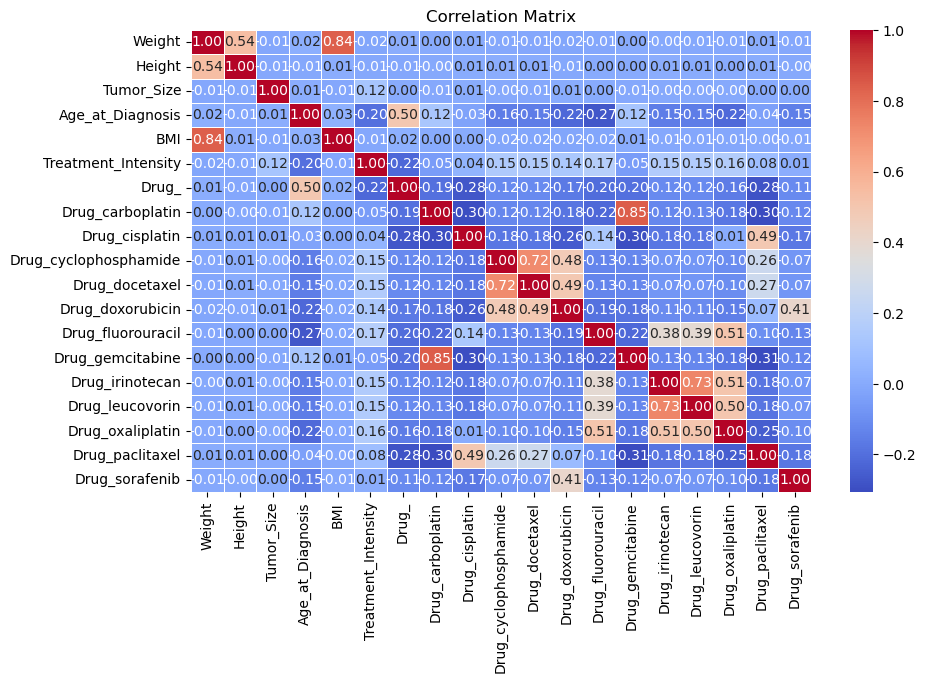

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_train[numerical_features].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()



In [39]:
#now we drop one of the two columns that have a high correlation
def correlation(dataset, threshold):
    col_corr = set()  
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i] 
                col_corr.add(colname)
    return col_corr

corr_features = correlation(df_train[numerical_features], 0.95)
len(set(corr_features))

0

In [40]:
df_train.head()

Weight    Height  Family_History  Tumor_Size  Radiation_Sessions  \
0 -0.416242 -1.314756               0    0.063101                  16   
1 -0.580102 -0.110766               1    0.543756                  10   
2 -0.612874 -0.186016               0    1.264739                  21   
3 -0.168111 -0.110766               1   -1.138537                  10   
4  1.241086  1.017974               1    1.024411                   6   

   Immunotherapy  Targeted_Therapy  Recurrence_Status  Smoking_History  \
0              0                 1                  0                2   
1              0                 0                  1                1   
2              1                 0                  0                1   
3              0                 1                  0                2   
4              1                 0                  1                1   

   Alcohol_Use  ...  Symptom_  Symptom_bloodinstool  Symptom_cough  \
0            2  ...         0                     0              1   
1            2  ...         0                     1              0   
2            0  ...         0                     0              0   
3            2  ...         0                     0              0   
4            0  ...         0                     0              1   

   Symptom_fatigue  Symptom_lump  Symptom_nausea  Symptom_pain  \
0                0             0               0             0   
1                0             0               0             0   
2                0             0               1             0   
3                0             0               1             0   
4                0             0               0             0   

   Symptom_swelling  Symptom_vomiting  Symptom_weightloss  
0                 0                 0                   1  
1                 0                 0                   0  
2                 0                 1                   0  
3                 0                 1                   0  
4                 0                 0                   1  

[5 rows x 63 columns]

In [41]:
bool_cols = [col for col in df_train.columns if df_train[col].dtype == bool]

df_train[bool_cols] = df_train[bool_cols].astype(int)
df_test[bool_cols] = df_test[bool_cols].astype(int)

# 3. Verify conversion
print("Boolean features converted to:")
df_train.head(3)

Boolean features converted to:


Weight    Height  Family_History  Tumor_Size  Radiation_Sessions  \
0 -0.416242 -1.314756               0    0.063101                  16   
1 -0.580102 -0.110766               1    0.543756                  10   
2 -0.612874 -0.186016               0    1.264739                  21   

   Immunotherapy  Targeted_Therapy  Recurrence_Status  Smoking_History  \
0              0                 1                  0                2   
1              0                 0                  1                1   
2              1                 0                  0                1   

   Alcohol_Use  ...  Symptom_  Symptom_bloodinstool  Symptom_cough  \
0            2  ...         0                     0              1   
1            2  ...         0                     1              0   
2            0  ...         0                     0              0   

   Symptom_fatigue  Symptom_lump  Symptom_nausea  Symptom_pain  \
0                0             0               0             0   
1                0             0               0             0   
2                0             0               1             0   

   Symptom_swelling  Symptom_vomiting  Symptom_weightloss  
0                 0                 0                   1  
1                 0                 0                   0  
2                 0                 1                   0  

[3 rows x 63 columns]

In [42]:
print("NaN values in training set:", df_train.isnull().sum().sum())
print("NaN values in test set:", df_test.isnull().sum().sum())

NaN values in training set: 0
NaN values in test set: 0


In [532]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

# Assuming you have already done preprocessing, and df_train & df_test are ready

# Prepare training and test data
X_train = df_train.drop('label', axis=1)
y_train = df_train['label']
X_test = df_test.drop(columns=['id'])  # Test set (no labels)

# 2. Train and Evaluate Models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

# Training and evaluation loop
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the training set
    y_train_pred = model.predict(X_train)

    # Evaluate model performance on the training set
    print(f"{model_name} - Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"{model_name} - Classification Report on Training Set:")
    print(classification_report(y_train, y_train_pred))

    # Optionally, check confusion matrix
    print(f"{model_name} - Confusion Matrix:")
    print(confusion_matrix(y_train, y_train_pred))

    # Predict on the test set (no labels)
    y_test_pred = model.predict(X_test)

    # Prepare the submission file for each model
    submission = pd.DataFrame({
        'id': df_test['id'].astype('int'),  # Ensure 'id' is integer
        'label': y_test_pred
    })

    # Save the predictions to CSV for each model
    submission.to_csv(f'{model_name.lower().replace(" ", "_")}_submission.csv', index=False)
    print(f"{model_name} predictions saved as '{model_name.lower().replace(' ', '_')}_submission.csv'")

# 3. Hyperparameter Tuning with GridSearchCV for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1]
}

# Perform GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(
    XGBClassifier(random_state=42),
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy'
)
grid_search_xgb.fit(X_train, y_train)

# Best Parameters and Accuracy for XGBoost from GridSearch
print("\nBest Parameters for XGBoost (GridSearch):", grid_search_xgb.best_params_)
print("Best CV Accuracy for XGBoost (GridSearch):", grid_search_xgb.best_score_)

# Final Model - Use the best performing model (XGBoost with grid search) for prediction
best_model_xgb = grid_search_xgb.best_estimator_  # Best model from grid search

# Predict on the test set for XGBoost
y_test_pred_xgb = best_model_xgb.predict(X_test)

# Prepare submission file for XGBoost (from GridSearch)
submission_xgb = pd.DataFrame({
    'id': df_test['id'].astype('int'),  # Ensure 'id' is integer
    'label': y_test_pred_xgb
})

# Save the XGBoost predictions to CSV
submission_xgb.to_csv('xgboost_submission_from_gridsearch.csv', index=False)
print("XGBoost predictions saved as 'xgboost_submission_from_gridsearch.csv'")

# Add XGBoost Accuracy on training data after GridSearch
y_train_pred_xgb = best_model_xgb.predict(X_train)
print(f"XGBoost - Training Accuracy (after GridSearch): {accuracy_score(y_train, y_train_pred_xgb):.4f}")



Training Logistic Regression...
Logistic Regression - Training Accuracy: 0.6505
Logistic Regression - Classification Report on Training Set:
              precision    recall  f1-score   support

           0       0.66      0.68      0.67     13614
           1       0.65      0.62      0.63     12859

    accuracy                           0.65     26473
   macro avg       0.65      0.65      0.65     26473
weighted avg       0.65      0.65      0.65     26473

Logistic Regression - Confusion Matrix:
[[9213 4401]
 [4852 8007]]
Logistic Regression predictions saved as 'logistic_regression_submission.csv'

Training Random Forest...
Random Forest - Training Accuracy: 1.0000
Random Forest - Classification Report on Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13614
           1       1.00      1.00      1.00     12859

    accuracy                           1.00     26473
   macro avg       1.00      1.00      1.00 

In [533]:
# Import necessary libraries
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Assuming df_train and df_test are already preprocessed

# Feature columns and target variable
X_train = df_train.drop(columns=['label'])  # Drop the target variable 'label'
y_train = df_train['label']

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# **Logistic Regression Model**
log_reg = LogisticRegression(class_weight='balanced', max_iter=200, random_state=42)
log_reg.fit(X_train_res, y_train_res)

# Make predictions on the training set using Logistic Regression
y_train_pred_lr = log_reg.predict(X_train_res)

# Evaluate Logistic Regression performance
lr_accuracy = accuracy_score(y_train_res, y_train_pred_lr)
print(f"Logistic Regression - Training Accuracy: {lr_accuracy:.4f}")
print(classification_report(y_train_res, y_train_pred_lr))

# Save Logistic Regression results to CSV
lr_predictions = log_reg.predict(df_test.drop(columns=['id']))  # Assuming df_test is preprocessed
lr_submission = pd.DataFrame({
    'id': df_test['id'],
    'label': lr_predictions
})
lr_submission.to_csv('logistic_regression_submission.csv', index=False)
print("Logistic Regression predictions saved to 'logistic_regression_submission.csv'")

# **Random Forest Model**
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train_res, y_train_res)

# Make predictions on the training set using Random Forest
y_train_pred_rf = rf.predict(X_train_res)

# Evaluate Random Forest performance
rf_accuracy = accuracy_score(y_train_res, y_train_pred_rf)
print(f"Random Forest - Training Accuracy: {rf_accuracy:.4f}")
print(classification_report(y_train_res, y_train_pred_rf))

# Save Random Forest results to CSV
rf_predictions = rf.predict(df_test.drop(columns=['id']))  # Assuming df_test is preprocessed
rf_submission = pd.DataFrame({
    'id': df_test['id'].astype('int'),
    'label': rf_predictions
})
rf_submission.to_csv('random_forest_submission.csv', index=False)
print("Random Forest predictions saved to 'random_forest_submission.csv'")

# **XGBoost Model with Hyperparameter Tuning**
param_dist = {
    'n_estimators': [100, 150, 200],  # Number of trees (start small)
    'max_depth': [3, 6, 9],  # Depth of trees (try shallow trees for robustness)
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate (commonly effective values)
    'subsample': [0.7, 0.8, 0.9],  # Fraction of samples for each tree
}
# Initialize XGBoost classifier
xgb = XGBClassifier(random_state=42)

# Perform RandomizedSearchCV with 5-fold cross-validation
rand_search_xgb = RandomizedSearchCV(
    xgb, param_distributions=param_dist, n_iter=10,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='roc_auc', n_jobs=-1
)

rand_search_xgb.fit(X_train_res, y_train_res)

# Best parameters and model
print(f"Best Parameters for XGBoost: {rand_search_xgb.best_params_}")
print(f"Best CV AUC for XGBoost: {rand_search_xgb.best_score_:.4f}")

# Use the best XGBoost model
best_xgb_model = rand_search_xgb.best_estimator_

# Make predictions on the training set using the best XGBoost model
y_train_pred_xgb = best_xgb_model.predict(X_train_res)

# Evaluate XGBoost performance
xgb_accuracy = accuracy_score(y_train_res, y_train_pred_xgb)
print(f"XGBoost - Training Accuracy: {xgb_accuracy:.4f}")
print(classification_report(y_train_res, y_train_pred_xgb))

# Save XGBoost results to CSV
xgb_predictions = best_xgb_model.predict(df_test.drop(columns=['id']))  # Assuming df_test is preprocessed
xgb_submission = pd.DataFrame({
    'id': df_test['id'],
    'label': xgb_predictions
})
xgb_submission.to_csv('xgboost_submission.csv', index=False)
print("XGBoost predictions saved to 'xgboost_submission.csv'")





c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - Training Accuracy: 0.6600
              precision    recall  f1-score   support

           0       0.66      0.68      0.67     13614
           1       0.67      0.64      0.65     13614

    accuracy                           0.66     27228
   macro avg       0.66      0.66      0.66     27228
weighted avg       0.66      0.66      0.66     27228

Logistic Regression predictions saved to 'logistic_regression_submission.csv'
Random Forest - Training Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13614
           1       1.00      1.00      1.00     13614

    accuracy                           1.00     27228
   macro avg       1.00      1.00      1.00     27228
weighted avg       1.00      1.00      1.00     27228

Random Forest predictions saved to 'random_forest_submission.csv'
Best Parameters for XGBoost: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05}
Best

In [48]:
# Import necessary libraries
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import os

# Create a writable directory for CatBoost temporary files
train_dir = r'C:\Users\Lenovo\Documents\CatBoost_Temp'
if not os.path.exists(train_dir):
    os.makedirs(train_dir)

# Feature columns and target variable (already defined in your code)
X_train = df_train.drop(columns=['label'])
y_train = df_train['label']

# **CatBoost Model with Hyperparameter Tuning**
param_dist_catboost = {
    'iterations': [100, 150, 200],  # Number of trees (similar to n_estimators)
    'depth': [4, 6, 8],  # Depth of trees
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'l2_leaf_reg': [1, 3, 5],  # L2 regularization
    'subsample': [0.7, 0.8, 0.9],  # Fraction of samples for each tree
}

# Initialize CatBoost classifier with custom train_dir
catboost = CatBoostClassifier(random_state=42, verbose=0, train_dir=train_dir)

# Perform RandomizedSearchCV with 3-fold cross-validation
rand_search_catboost = RandomizedSearchCV(
    catboost, param_distributions=param_dist_catboost, n_iter=10,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='roc_auc', n_jobs=-1, error_score='raise'  # Set error_score='raise' for debugging
)

# Fit the model
try:
    rand_search_catboost.fit(X_train_res, y_train_res)
except Exception as e:
    print(f"Error during CatBoost fitting: {e}")
    raise

# Best parameters and model
print(f"Best Parameters for CatBoost: {rand_search_catboost.best_params_}")
print(f"Best CV AUC for CatBoost: {rand_search_catboost.best_score_:.4f}")

# Use the best CatBoost model
best_catboost_model = rand_search_catboost.best_estimator_

# Make predictions on the training set using the best CatBoost model
y_train_pred_catboost = best_catboost_model.predict(X_train_res)

# Evaluate CatBoost performance
catboost_accuracy = accuracy_score(y_train_res, y_train_pred_catboost)
print(f"CatBoost - Training Accuracy: {catboost_accuracy:.4f}")
print(classification_report(y_train_res, y_train_pred_catboost))

# Save CatBoost results to CSV
catboost_predictions = best_catboost_model.predict(df_test.drop(columns=['id']))
catboost_submission = pd.DataFrame({
    'id': df_test['id'],
    'label': catboost_predictions
})
catboost_submission.to_csv('catboost_submission.csv', index=False)
print("CatBoost predictions saved to 'catboost_submission.csv'")

Best Parameters for CatBoost: {'subsample': 0.8, 'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 200, 'depth': 8}
Best CV AUC for CatBoost: 0.8841
CatBoost - Training Accuracy: 0.8246
              precision    recall  f1-score   support

           0       0.83      0.82      0.82     13614
           1       0.82      0.83      0.83     13614

    accuracy                           0.82     27228
   macro avg       0.82      0.82      0.82     27228
weighted avg       0.82      0.82      0.82     27228

CatBoost predictions saved to 'catboost_submission.csv'


In [44]:
!pip install catboost

   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/102.4 MB ? eta -:--:--
    --------------------------------------- 1.3/102.4 MB 3.0 MB/s eta 0:00:34
    --------------------------------------- 1.8/102.4 MB 3.1 MB/s eta 0:00:32
   - -------------------------------------- 2.6/102.4 MB 3.0 MB/s eta 0:00:34
   - -------------------------------------- 3.1/102.4 MB 2.8 MB/s eta 0:00:36
   - -------------------------------------- 3.9/102.4 MB 3.2 MB/s eta 0:00:32
   - -------------------------------------- 4.7/102.4 MB 3.1 MB/s eta 0:00:32
   -- ------------------------------------- 5.2/102.4 MB 3.2 MB/s eta 0:00:31
   -- ------------------------------------- 6.3/102.4 MB 3.1 MB/s eta 0:00:31
   -- ------------------------------------- 6.8/102.4 MB 3.1 MB/s eta 0:00:31
   -- ------------------------------------- 7.3/102.4 MB 3.1 MB/s eta 0:00:31
   --- ------------------------------------ 8.1/102.4 MB 3.1 MB/s eta 0:00:31
